sparse depth estimation
- image rectification for stereo image pair
- detect key feature points (e.g., using SIFT)
- match features between left and right images
- compute disparity at matched keypoints
- estimate depth for these sparse points

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

load stereo images

In [2]:
imgL_col = cv2.imread("left_image.jpg")
imgL = cv2.cvtColor(imgL_col, cv2.COLOR_BGR2GRAY)
imgL_col = cv2.cvtColor(imgL_col, cv2.COLOR_BGR2RGB)

imgR_col = cv2.imread("right_image.jpg")
imgR = cv2.cvtColor(imgR_col, cv2.COLOR_BGR2GRAY)
imgR_col = cv2.cvtColor(imgR_col, cv2.COLOR_BGR2RGB)

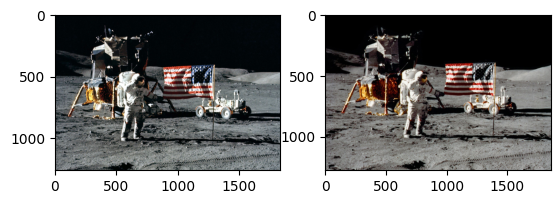

In [3]:
plt.subplot(121)
plt.imshow(imgL_col)
plt.subplot(122)
plt.imshow(imgR_col)

In [4]:
# camera parameters (just default values here)
K1 = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]])  # intrinsic matrix for left camera
K2 = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]])  # intrinsic matrix for right camera
D1 = np.zeros(5)  # distortion coefficients for left camera
D2 = np.zeros(5)  # distortion coefficients for right camera
R = np.eye(3)  # rotation matrix (from stereo calibration)
T = np.array([[0.1, 0, 0]]).T  # translation vector (10 cm baseline)

# compute rectification transforms
image_size = (imgL.shape[1], imgL.shape[0])
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K1, D1, K2, D2, image_size, R, T)

# compute rectification maps
map1L, map2L = cv2.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv2.CV_16SC2)
map1R, map2R = cv2.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv2.CV_16SC2)

# apply rectification
imgL_rect = cv2.remap(imgL, map1L, map2L, cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, map1R, map2R, cv2.INTER_LINEAR)

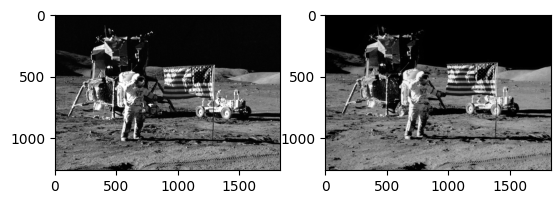

In [5]:
plt.subplot(121)
plt.imshow(imgL_rect, cmap='gray', vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(imgR_rect, cmap='gray', vmin=0, vmax=255)

In [6]:
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(imgL_rect, None)
keypoints2, descriptors2 = sift.detectAndCompute(imgR_rect, None)
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:50]

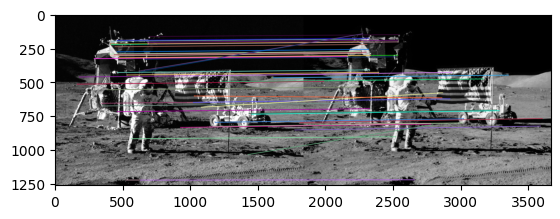

In [7]:
image_matched = cv2.drawMatches(imgL_rect, keypoints1, imgR_rect, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=3)
plt.imshow(image_matched, cmap='gray', vmin=0, vmax=255)

extract point coordinates

In [8]:
left_points = np.float32([keypoints1[m.queryIdx].pt for m in matches])
right_points = np.float32([keypoints2[m.trainIdx].pt for m in matches])

compute disparities (difference in x-coordinates)

In [9]:
disparities = right_points[:, 0] - left_points[:, 0]
disparities

array([-7.91992188e-01,  2.53292847e+01,  1.13535156e+01, -2.25756836e+01,
       -1.93468933e+01, -2.25756836e+01, -8.15307617e+00,  2.79472961e+01,
        2.58288574e+01,  1.04969360e+02,  2.59925232e+01,  2.52902222e+01,
        1.58875732e+01, -1.93468933e+01,  2.73964233e+01,  1.02936279e+02,
        2.10982666e+01, -1.88859863e+02,  1.91984985e+02,  3.14075928e+01,
        2.81712341e+01, -4.74382324e+01,  2.91925964e+01,  5.88294678e+01,
        2.55003357e+01,  2.41658936e+01, -5.46273193e+01, -9.99680176e+01,
        2.39390869e+01,  1.14658203e+01,  2.43370667e+01, -7.94905518e+02,
        1.08825745e+02,  2.41658936e+01, -4.71643555e+02, -7.91992188e-01,
        1.18070740e+02, -6.98693848e+00,  2.43713379e+01,  1.06752319e+01,
       -7.28637695e-01, -6.39642334e+00,  1.87794556e+02,  1.59606934e+01,
       -1.00618408e+02,  2.49118958e+01, -1.37487335e+01,  1.38624268e+01,
       -1.82510437e+02,  2.33336487e+01], dtype=float32)

In [10]:
y_deviations = np.abs(right_points[:, 1] - left_points[:, 1])
y_deviations

array([ 25.926514  ,  16.517502  ,  15.582626  ,  28.92804   ,
        19.265656  ,  28.92804   ,  25.921509  ,  21.07367   ,
        18.352081  ,  21.851501  ,  16.515442  ,  16.91835   ,
        18.052185  ,  19.265656  ,  22.232422  ,  26.71283   ,
        19.70868   , 282.0402    ,   0.51538086,  17.101929  ,
        21.666382  ,  28.522888  ,  20.940369  ,  25.992554  ,
        17.929443  ,  19.137665  , 106.243774  ,  20.219818  ,
        17.78299   ,  15.940231  ,  16.485168  ,   0.7470703 ,
        26.791779  ,  19.137665  , 219.24335   ,  25.926514  ,
        14.543396  ,  25.59082   ,  15.883835  ,  13.546967  ,
        26.105774  ,  14.325195  ,   2.1031494 ,  18.019623  ,
        19.573547  ,  16.933899  ,  20.965668  ,  24.092651  ,
       274.54376   ,  18.29721   ], dtype=float32)

In [11]:
y_deviations.mean()

np.float32(35.372868)

In [12]:
mask = (y_deviations < 30) & (disparities > 0)
left_points = left_points[mask]
disparities = disparities[mask]

In [13]:
disparities

array([ 25.329285,  11.353516,  27.947296,  25.828857, 104.96936 ,
        25.992523,  25.290222,  15.887573,  27.396423, 102.93628 ,
        21.098267, 191.98499 ,  31.407593,  28.171234,  29.192596,
        58.829468,  25.500336,  24.165894,  23.939087,  11.46582 ,
        24.337067, 108.825745,  24.165894, 118.07074 ,  24.371338,
        10.675232, 187.79456 ,  15.960693,  24.911896,  13.862427,
        23.333649], dtype=float32)

In [14]:
disparities.mean()

np.float32(45.645023)

camera parameters (just guesses here)

In [15]:
focal_length = 800  # in pixels
baseline = 0.1  # in meters

In [16]:
depths = (focal_length * baseline) / disparities

visualize sparse depth points

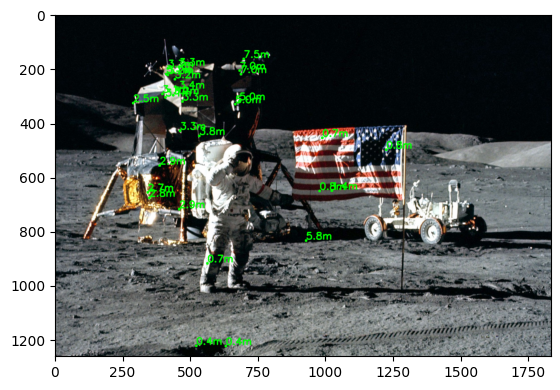

In [17]:
for i in range(len(disparities)):
    x, y = map(int, left_points[i])
    depth = depths[i]
    cv2.circle(imgL_col, (x, y), 5, (0, 255, 0), -1)
    cv2.putText(imgL_col, f"{depth:.1f}m", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

plt.imshow(imgL_col, cmap='gray', vmin=0, vmax=255)